In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf




In [2]:
timestep=[]
sunspots=[]

with open('Sunspots.csv') as csvfile:
    reader=csv.reader(csvfile)
    next(reader)
    for line in reader:
        timestep.append(int(line[0]))
        sunspots.append(float(line[2]))

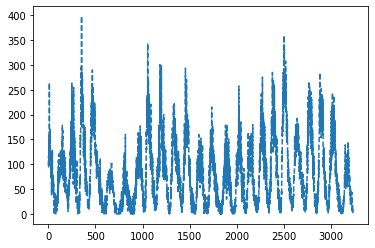

In [3]:
plt.plot(timestep,sunspots,'--')
plt.interactive(False)
plt.show()



In [4]:

timestep=np.array(timestep)
sunspots=np.array(sunspots)

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
 #   series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
batch_size=32
window_size=50
shuffle_buffer=4000
trainsize=int(len(sunspots)*0.8)
sunspots_train=sunspots[:trainsize]
timestep_train=timestep[:trainsize]
sunspots_test=sunspots[trainsize:]
timestep_test=timestep[trainsize:]

In [7]:
dataset_train=windowed_dataset(sunspots_train,window_size,batch_size,shuffle_buffer)



In [8]:
model=tf.keras.models.Sequential([tf.keras.layers.Dense(10,input_shape=[window_size],activation='relu'),
                                  tf.keras.layers.Dense(10,activation='relu'),
                                  tf.keras.layers.Dense(1),
                                  tf.keras.layers.Lambda(lambda x:x*200)])
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(optimizer=optimizer,loss=tf.keras.losses.Huber(),metrics=['mae'])
model.fit(dataset_train,batch_size=batch_size,epochs=100)
model.save('sunspotmodel')
dataset_test=windowed_dataset(sunspots_test,window_size,batch_size,shuffle_buffer)
model.evaluate(dataset_test)

Epoch 1/100
80/80 [==============================] - 0s 4ms/step - loss: 2692.8750 - mae: 2693.3748
Epoch 2/100
80/80 [==============================] - 0s 1ms/step - loss: 1839.1646 - mae: 1839.6646
Epoch 3/100
80/80 [==============================] - 0s 1ms/step - loss: 1285.8867 - mae: 1286.3867
Epoch 4/100
80/80 [==============================] - 0s 1ms/step - loss: 950.0494 - mae: 950.5491
Epoch 5/100
80/80 [==============================] - 0s 1ms/step - loss: 740.8057 - mae: 741.3054
Epoch 6/100
80/80 [==============================] - 0s 1ms/step - loss: 592.9839 - mae: 593.4834
Epoch 7/100
80/80 [==============================] - 0s 1ms/step - loss: 474.5977 - mae: 475.0971
Epoch 8/100
80/80 [==============================] - 0s 1ms/step - loss: 378.5225 - mae: 379.0214
Epoch 9/100
80/80 [==============================] - 0s 1ms/step - loss: 297.9420 - mae: 298.4407
Epoch 10/100
80/80 [==============================] - 0s 1ms/step - loss: 240.4487 - mae: 240.9471
Epoch 11/100


80/80 [==============================] - 0s 1ms/step - loss: 48.7633 - mae: 49.2601
Epoch 86/100
80/80 [==============================] - 0s 1ms/step - loss: 48.2731 - mae: 48.7699
Epoch 87/100
80/80 [==============================] - 0s 1ms/step - loss: 48.6051 - mae: 49.1020
Epoch 88/100
80/80 [==============================] - 0s 1ms/step - loss: 48.2583 - mae: 48.7551
Epoch 89/100
80/80 [==============================] - 0s 1ms/step - loss: 48.0681 - mae: 48.5649
Epoch 90/100
80/80 [==============================] - 0s 1ms/step - loss: 47.8410 - mae: 48.3377
Epoch 91/100
80/80 [==============================] - 0s 1ms/step - loss: 48.0773 - mae: 48.5741
Epoch 92/100
80/80 [==============================] - 0s 1ms/step - loss: 48.1470 - mae: 48.6438
Epoch 93/100
80/80 [==============================] - 0s 1ms/step - loss: 47.7822 - mae: 48.2789
Epoch 94/100
80/80 [==============================] - 0s 1ms/step - loss: 48.1192 - mae: 48.6161
Epoch 95/100
80/80 [=======================

[36.95321273803711, 37.45048141479492]

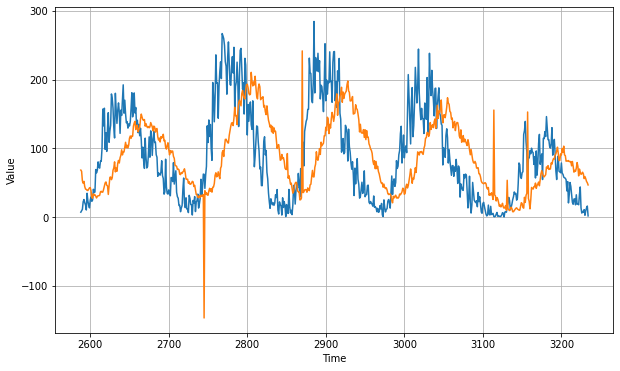

In [9]:

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, sunspots, window_size)
rnn_forecast = rnn_forecast[trainsize - window_size:-1, -1]

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


plt.figure(figsize=(10, 6))
plot_series(timestep_test, sunspots_test)
plot_series(timestep_test, rnn_forecast)
plt.show()